In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Step 1: Initialize Spark Session
spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()

# Step 2: Load the dataset
file_path = "Customer_Data.csv"  # Change this to your file path
df = spark.read.csv(file_path, header=True, inferSchema=True)



In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator

# Step 1: Create Spark session
spark = SparkSession.builder.appName("PimaClustering").getOrCreate()

# Step 2: Load the dataset
df = spark.read.csv("/content/pima.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

# Step 3: Assemble features into a single vector column
feature_cols = df.columns  # assuming all columns are numeric
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(df)

# Step 4: Apply KMeans clustering
kmeans = KMeans(k=3, seed=1, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(data)

# Step 5: Make predictions
predictions = model.transform(data)
predictions.select("cluster", *feature_cols).show(10)

# Step 6: Evaluate clustering by Silhouette score


root
 |-- preg: integer (nullable = true)
 |-- plas: integer (nullable = true)
 |-- pres: integer (nullable = true)
 |-- skin: integer (nullable = true)
 |-- test: integer (nullable = true)
 |-- mass: double (nullable = true)
 |-- pedi: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- class: integer (nullable = true)

+----+----+----+----+----+----+-----+---+-----+
|preg|plas|pres|skin|test|mass| pedi|age|class|
+----+----+----+----+----+----+-----+---+-----+
|   6| 148|  72|  35|   0|33.6|0.627| 50|    1|
|   1|  85|  66|  29|   0|26.6|0.351| 31|    0|
|   8| 183|  64|   0|   0|23.3|0.672| 32|    1|
|   1|  89|  66|  23|  94|28.1|0.167| 21|    0|
|   0| 137|  40|  35| 168|43.1|2.288| 33|    1|
+----+----+----+----+----+----+-----+---+-----+
only showing top 5 rows

+-------+----+----+----+----+----+----+-----+---+-----+
|cluster|preg|plas|pres|skin|test|mass| pedi|age|class|
+-------+----+----+----+----+----+----+-----+---+-----+
|      1|   6| 148|  72|  35|   0|33.6

In [8]:
kmeans = KMeans(k=3, seed=1, featuresCol="features")  # Don't override predictionCol
model = kmeans.fit(data)

# This will create a column named 'prediction'
predictions = model.transform(data)


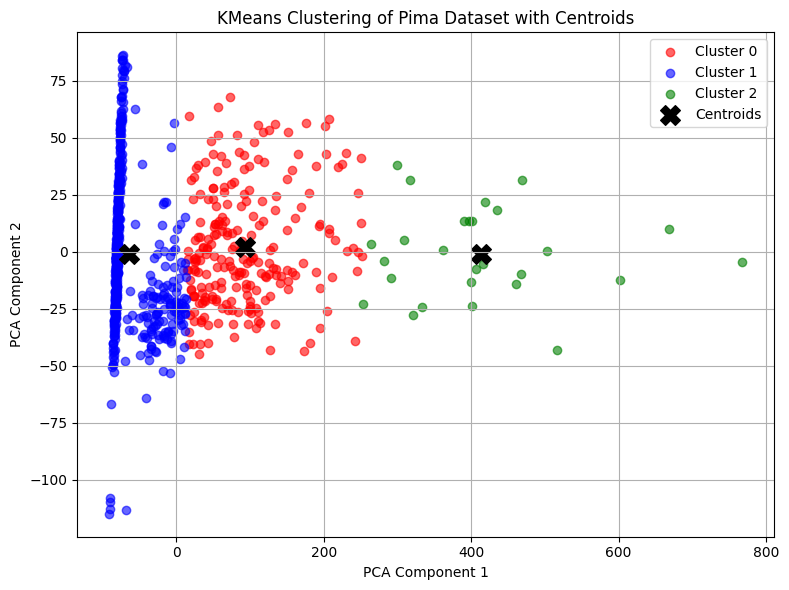

In [9]:
# Convert to Pandas for visualization
pandas_df = predictions.select("features", "prediction").toPandas()

# Convert Spark DenseVector to list
X = pandas_df['features'].apply(lambda x: x.toArray()).tolist()
labels = pandas_df['prediction']

# PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2)
components = pca.fit_transform(X)

# Transform cluster centers using same PCA
centers = model.clusterCenters()  # this is a list of numpy arrays
centers_2d = pca.transform(centers)

# Plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']

for cluster_id in range(len(set(labels))):
    idx = labels == cluster_id
    plt.scatter(
        [components[i][0] for i in range(len(components)) if idx[i]],
        [components[i][1] for i in range(len(components)) if idx[i]],
        label=f'Cluster {cluster_id}',
        c=colors[cluster_id],
        alpha=0.6
    )

# Plot centroids
plt.scatter(
    centers_2d[:, 0],
    centers_2d[:, 1],
    s=200,
    c='black',
    marker='X',
    label='Centroids'
)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering of Pima Dataset with Centroids')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
